### Set up

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from IPython import display

Loading word2vec model, getting its keyword vectors

In [5]:
import gensim.downloader as api
from gensim.models import KeyedVectors
model_name = 'word2vec-google-news-300'
wv: KeyedVectors = api.load(model_name)

Loading dataset into pandas dataframe.

Score column represents how man times annotators considered this pair of two words **more similar** that another word pair of two words. Each annotator was given two words pairs 50 times, where he had to choose a pair of words, where two words are more similar to each other then in another pair. 

In [1]:
import pandas as pd

men_dataset_path = "../../datasets/MEN/MEN_dataset_natural_form_full"

# Read the data into a pandas DataFrame
df = pd.read_csv(
    men_dataset_path, sep=" ", header=None, names=["word1", "word2", "score"]
)

# Display the first 10 rows
df.head(10)

,word1,word2,score
0,sun,sunlight,50.0
1,automobile,car,50.0
2,river,water,49.0
3,stairs,staircase,49.0
4,morning,sunrise,49.0
5,rain,storm,49.0
6,cat,kittens,49.0
7,dance,dancers,49.0
8,camera,photography,49.0
9,cat,feline,48.0


The score is not absolute value, it is relative to another pair. That is we such word pairs like angel-gasoline were chosen by some annotator, because the annotator probably could have choose between, for example, angel-gasoline and bakery-zebra words pairs.

In [2]:
df.tail(10)

,word1,word2,score
2990,posted,tulip,2.0
2991,grave,hat,2.0
2992,apple,cute,2.0
2993,angel,gasoline,1.0
2994,giraffe,harbor,1.0
2995,feathers,truck,1.0
2996,festival,whiskers,1.0
2997,muscle,tulip,1.0
2998,bikini,pizza,1.0
2999,bakery,zebra,0.0


### Normalization of scores and shuffling

Normalizing score column to be a value from 0 to 1

Also, let's shuffle data

In [3]:
df["score"] = df["score"] / 50
df = df.sample(frac=1, random_state=42)
df.head(10)

,word1,word2,score
1801,jean,washing,0.42
1190,blurred,lens,0.60
1817,lunch,morning,0.42
251,daffodils,plant,0.84
2505,animals,sandwich,0.22
1117,bathroom,floor,0.62
1411,birds,wild,0.54
2113,animals,clown,0.32
408,cafe,lunch,0.80
2579,friends,rusty,0.20


### Computing similarity scores using word2vec model

In [6]:
def similarity(word1: str, word2: str, model: KeyedVectors) -> float | None:
    if word1 not in model or word2 not in model:
        return None
    return model.similarity(word1, word2)


df["similarity"] = df.apply(
    lambda row: similarity(row["word1"], row["word2"], model=wv), axis=1
)

df.head(10)

,word1,word2,score,similarity
1801,jean,washing,0.42,0.074775
1190,blurred,lens,0.60,0.260104
1817,lunch,morning,0.42,0.351169
251,daffodils,plant,0.84,0.170391
2505,animals,sandwich,0.22,0.019091
1117,bathroom,floor,0.62,0.345373
1411,birds,wild,0.54,0.343737
2113,animals,clown,0.32,0.219066
408,cafe,lunch,0.80,0.361107
2579,friends,rusty,0.20,0.039733


### OOV statistics

In [10]:
OOV_pairs = df[df['similarity'].isnull()]
OOV_pairs.head(10)

,word1,word2,score,similarity
314,beach,harbour,0.82,NaN
2377,theatre,wolf,0.24,NaN
1321,harbour,town,0.56,NaN
486,blue,grey,0.78,NaN
433,bright,colour,0.78,NaN
1105,dark,grey,0.62,NaN
2627,held,theatre,0.18,NaN
170,colour,pink,0.86,NaN
831,black,colour,0.70,NaN
1413,cliff,harbour,0.54,NaN


In [17]:
total_rows_number = df.shape[0]
display(f"Total rows number: {total_rows_number}")

oov_rows_number = OOV_pairs.shape[0]
display(f"Total OOV rows number: {oov_rows_number}")

ratio = oov_rows_number/total_rows_number
display(f"Ratio: {ratio}")

'Total rows number: 3000'

'Total OOV rows number: 54'

'Ratio: 0.018'

### Normalizing similarity scores using linear transformations and linear scaling

Problem is that normalized score's range is [0.0, 1.0], when similarity function range is bound to cosine range [-1.0, 1.0]

Thus, we can see negative similiarity scores:

In [23]:
similarity = df['similarity']
min_value = similarity.min()
max_value = similarity.max()
display(f"Max: {max_value}",f"Min: {min_value}")

'Max: 0.8766965866088867'

'Min: -0.08152719587087631'

To solve proble above, let's normalize range [-1.0, 1.0] to [0.0, 1.0]

Let's use linear transformation - translate range [-1, 1] to [0, 2] and then scale whole range by 0.5

In such transformation, values in:
- [0.0, 0.5) are considered to have different directions in the embedding space
- (0.5, 1.0] are considered to have same directions in the embedding space

In [38]:
def linear_normalization(similarity_value: float) -> float:
    return 0.5 * (similarity_value + 1)


# Filter out rows with 'None' similarity
df_filtered = df[df["similarity"].notnull()].copy()
df_filtered['transformed_similarity'] = df_filtered["similarity"].apply(
    linear_normalization
)
df_filtered.head(10)

,word1,word2,score,similarity,transformed_similarity
1801,jean,washing,0.42,0.074775,0.537387
1190,blurred,lens,0.60,0.260104,0.630052
1817,lunch,morning,0.42,0.351169,0.675584
251,daffodils,plant,0.84,0.170391,0.585196
2505,animals,sandwich,0.22,0.019091,0.509545
1117,bathroom,floor,0.62,0.345373,0.672686
1411,birds,wild,0.54,0.343737,0.671869
2113,animals,clown,0.32,0.219066,0.609533
408,cafe,lunch,0.80,0.361107,0.680554
2579,friends,rusty,0.20,0.039733,0.519867


### Binary classification using thresholds

In [46]:
actual_class_threshold = 0.5
predicted_class_threshold = 0.5
df_filtered["actual_class"] = df_filtered["score"] > actual_class_threshold
df_filtered["predicted_class"] = df_filtered["transformed_similarity"] > predicted_class_threshold

df_filtered.head(10)

,word1,word2,score,similarity,transformed_similarity,actual_class,predicted_class
1801,jean,washing,0.42,0.074775,0.537387,False,True
1190,blurred,lens,0.60,0.260104,0.630052,True,True
1817,lunch,morning,0.42,0.351169,0.675584,False,True
251,daffodils,plant,0.84,0.170391,0.585196,True,True
2505,animals,sandwich,0.22,0.019091,0.509545,False,True
1117,bathroom,floor,0.62,0.345373,0.672686,True,True
1411,birds,wild,0.54,0.343737,0.671869,True,True
2113,animals,clown,0.32,0.219066,0.609533,False,True
408,cafe,lunch,0.80,0.361107,0.680554,True,True
2579,friends,rusty,0.20,0.039733,0.519867,False,True


Now let's use binary classification statistics:

In [43]:
import numpy as np

y_true = np.where(df_filtered["actual_class"], 1, 0)
y_pred = np.where(df_filtered["predicted_class"], 1, 0)

### Statistics

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f_score = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

display(
    f"Actual class threshold: {actual_class_threshold}",
    f"Predicted class threshold: {predicted_class_threshold}",
    f"Precision: {precision}",
    f"recall: {recall}",
    f"f_score: {f_score}",
    f"accuracy: {accuracy}",
)

'Actual class threshold: 0.5'

'Predicted class threshold: 0.5'

'Precision: 0.5043448036148767'

'recall: 1.0'

'f_score: 0.6705175600739373'

'accuracy: 0.5159538357094365'

In [49]:
from sklearn.metrics import precision_recall_curve
y_trans_similarity_scores = df_filtered['transformed_similarity'].to_numpy()

precision, recall, thresholds = precision_recall_curve(y_true, y_trans_similarity_scores)

display(thresholds)

array([0.4592364 , 0.46207891, 0.46296392, ..., 0.93426979, 0.9353117 ,
       0.93834829])

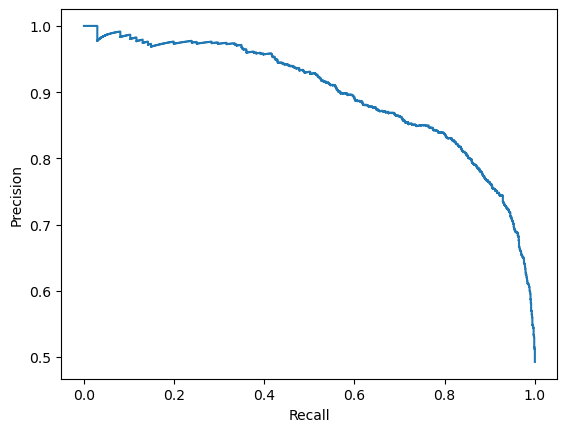

In [54]:
from sklearn.metrics import PrecisionRecallDisplay
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()